Clustering Metabolites from iHMP Data

In [4]:
# Setup

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from pymc3.gp.util import plot_gp_dist
import time
import pickle

In [5]:
# Read in metabolomics data
mbx = pd.read_csv('./data/iHMP_labeled_metabolomics.csv')
# Subset metabolites to labeled sets

# Get metabolite list
mbx_list = mbx.Metabolite
# Reshape metabolites for merge
mbx = mbx.iloc[:,7:].transpose().rename(columns = mbx_list)

# Read in metadata for timing of samples
meta = pd.read_csv('./data/iHMP_metadata.csv')
# Subset metadata to appropriate samples and columns of interest
meta = meta[meta['External ID'].isin(mbx.index)][['External ID', 'Participant ID', 
                                                  'date_of_receipt', 'diagnosis',
                                                  'hbi']]
meta.set_index('External ID', inplace = True)

In [6]:
# For the moment subset to 100 metabolites
mbx = mbx.iloc[:,:100]

In [7]:
print(mbx.shape)
mbx.head()

(546, 100)


12.13-diHOME  9.10-diHOME  caproate  heptanoate  hydrocinnamate  \
HSM5FZBJ     4355470.0    1512589.0    9636.0         NaN         40871.0   
MSM5FZ9X     2623839.0    2299190.0     100.0         NaN          8382.0   
CSM5FZ3N      942546.0    1418451.0    2194.0         NaN         38180.0   
ESM5MEDZ     5759125.0    3515867.0     161.0         NaN         58551.0   
MSM5FZA2     2231416.0    1589344.0     962.0         NaN          5542.0   

          mandelate  2-hydroxyoctanoate  3-hydroxyoctanoate   caprate  \
HSM5FZBJ     2693.0           1206893.0              4653.0  152127.0   
MSM5FZ9X     7233.0            440505.0             16683.0   25777.0   
CSM5FZ3N     5893.0                 NaN              4174.0  211440.0   
ESM5MEDZ    76155.0            963678.0             12477.0   15989.0   
MSM5FZA2     6246.0                 NaN              6664.0   31012.0   

          indoleacetate  ...  13-cis-retinoic acid  C14:0 LPC  C16:1 LPC  \
HSM5FZBJ         1875.0  ...                   NaN  1826449.0  2644468.0   
MSM5FZ9X         9631.0  ...                5316.0    32832.0   208850.0   
CSM5FZ3N        15667.0  ...                   NaN    48030.0    88541.0   
ESM5MEDZ         3302.0  ...                1006.0   197401.0  1155285.0   
MSM5FZA2         7806.0  ...                1678.0    22099.0   372039.0   

            C16:0 LPC   C18:2 LPC    C18:1 LPC    C18:0 LPC  C20:5 LPC  \
HSM5FZBJ  144042924.0  26088392.0  143051490.0  143854439.0  8245057.0   
MSM5FZ9X    3758012.0   1448452.0    1341494.0    1542011.0   387628.0   
CSM5FZ3N    6597595.0   3814195.0   12232874.0    1782624.0   971456.0   
ESM5MEDZ   21983828.0   7521089.0   10601477.0   17707878.0  2463097.0   
MSM5FZA2    4270489.0   1334038.0     919550.0    1497295.0   269998.0   

          C20:4 LPC   C20:3 LPC  
HSM5FZBJ  1883715.0  33406817.0  
MSM5FZ9X      547.0    538431.0  
CSM5FZ3N        NaN   1469531.0  
ESM5MEDZ    31215.0   5724622.0  
MSM5FZA2        NaN    748720.0  

[5 rows x 100 columns]

In [7]:
# Make sure that intensities are numeric and log transform them
log_mbx = np.log(mbx.astype('double'))

# Calculate the means and standard deviations of each column
log_means = log_mbx.mean()
log_stds = log_mbx.std()

# Transform dataset
log_mbx = (log_mbx - log_means)/log_stds

# Merge metabolomics info to metadata
df = (meta.merge(log_mbx, left_index = True, 
           right_index = True).
      drop_duplicates().
      rename(columns = {'Participant ID': 'id',
                        'date_of_receipt': 'date'#,
#                         0: 'intensity'
                       }))

# Fix the date column
df.date = pd.to_datetime(df.date)

# Now scale the dates compared to the earliest date
min_date = df.date.min()
df['days_from_start'] = (df.date - min_date).dt.days

# Drop columns that aren't needed (drop id for the moment)
df = df.drop(columns=['date'])#, 'id'])

# Drop duplicate metabolites
df = df.loc[:,~df.columns.duplicated()]

# Only keep CD observations because they have hbi
df = df.query("diagnosis == 'CD'").drop(columns = ['diagnosis'])

# Only keep non-missing HBI for the moment
df = df[df.hbi.notna()]

# Standardize hbi and days for convergence properties
df.days_from_start = (df.days_from_start - df.days_from_start.mean())/df.days_from_start.std()
df.hbi = (df.hbi - df.hbi.mean())/df.hbi.std()


print(df.shape)
df.head()

(241, 103)


id       hbi  12.13-diHOME  9.10-diHOME  caproate  heptanoate  \
CSM5FZ3N  C3001  0.628714     -0.409704     0.183670  0.003310         NaN   
CSM5FZ3T  C3002  2.563836     -1.244306    -1.342266 -1.831472         NaN   
CSM5FZ44  C3002  1.789787     -0.732257    -0.025969 -0.676471         NaN   
CSM5FZ4C  C3001  0.241690     -0.982568     0.583898  0.024073         NaN   
CSM5MCU4  C3008 -0.919384     -0.524664    -0.258498  0.128297         NaN   

          hydrocinnamate  mandelate  2-hydroxyoctanoate  3-hydroxyoctanoate  \
CSM5FZ3N       -0.610070  -0.303162                 NaN           -0.158171   
CSM5FZ3T       -1.231499  -0.186689                 NaN            0.173428   
CSM5FZ44       -1.390449   1.101909                 NaN            0.228417   
CSM5FZ4C       -0.293677   0.593005                 NaN            0.500679   
CSM5MCU4       -1.070318  -0.267726           -0.406852            0.965806   

          ...  C14:0 LPC  C16:1 LPC  C16:0 LPC  C18:2 LPC  C18:1 LPC  \
CSM5FZ3N  ...   0.038000  -0.620686  -0.189943   0.393291   0.982057   
CSM5FZ3T  ...   0.860854  -0.093752   0.443095   0.347706   0.839309   
CSM5FZ44  ...  -0.420366  -0.107086  -0.191411   0.491034   0.263393   
CSM5FZ4C  ...   0.902485   1.388829   1.270072   1.841497   1.615629   
CSM5MCU4  ...   0.109588  -0.176384   1.223771   1.722486   1.034418   

          C18:0 LPC  C20:5 LPC  C20:4 LPC  C20:3 LPC  days_from_start  
CSM5FZ3N  -0.272606   0.414464        NaN  -0.309204        -1.821219  
CSM5FZ3T   0.790110   0.437336  -0.336868   0.390754        -1.589634  
CSM5FZ44  -0.269124   0.294710        NaN   0.176111        -1.307705  
CSM5FZ4C   0.672784   1.626792   0.796049   1.388429        -1.539290  
CSM5MCU4   0.638052   1.512461   0.478147   1.284900        -1.272464  

[5 rows x 103 columns]

In [8]:
# Store individual information look up vectors
n_id = df.id.nunique()
id_list = df.id.unique()
id_vals = df.id.values
id_idx = np.array([np.where(id_list == x)[0][0] for x in id_vals])
df['id'] = id_idx

In [9]:
# # Modify data to creat dummies
# df = pd.get_dummies(df)


# # Standardize day column for convergence
# # df.days_from_start = (df.days_from_start - df.days_from_start.mean())/df.days_from_start.std()

# # Get the number of IDs
# num_ids = len([c for c in df.columns if c.startswith('id_')])
# id_list = [c for c in df.columns if c.startswith('id_')]
# num_ids

In [10]:
df.head()

id       hbi  12.13-diHOME  9.10-diHOME  caproate  heptanoate  \
CSM5FZ3N   0  0.628714     -0.409704     0.183670  0.003310         NaN   
CSM5FZ3T   1  2.563836     -1.244306    -1.342266 -1.831472         NaN   
CSM5FZ44   1  1.789787     -0.732257    -0.025969 -0.676471         NaN   
CSM5FZ4C   0  0.241690     -0.982568     0.583898  0.024073         NaN   
CSM5MCU4   2 -0.919384     -0.524664    -0.258498  0.128297         NaN   

          hydrocinnamate  mandelate  2-hydroxyoctanoate  3-hydroxyoctanoate  \
CSM5FZ3N       -0.610070  -0.303162                 NaN           -0.158171   
CSM5FZ3T       -1.231499  -0.186689                 NaN            0.173428   
CSM5FZ44       -1.390449   1.101909                 NaN            0.228417   
CSM5FZ4C       -0.293677   0.593005                 NaN            0.500679   
CSM5MCU4       -1.070318  -0.267726           -0.406852            0.965806   

          ...  C14:0 LPC  C16:1 LPC  C16:0 LPC  C18:2 LPC  C18:1 LPC  \
CSM5FZ3N  ...   0.038000  -0.620686  -0.189943   0.393291   0.982057   
CSM5FZ3T  ...   0.860854  -0.093752   0.443095   0.347706   0.839309   
CSM5FZ44  ...  -0.420366  -0.107086  -0.191411   0.491034   0.263393   
CSM5FZ4C  ...   0.902485   1.388829   1.270072   1.841497   1.615629   
CSM5MCU4  ...   0.109588  -0.176384   1.223771   1.722486   1.034418   

          C18:0 LPC  C20:5 LPC  C20:4 LPC  C20:3 LPC  days_from_start  
CSM5FZ3N  -0.272606   0.414464        NaN  -0.309204        -1.821219  
CSM5FZ3T   0.790110   0.437336  -0.336868   0.390754        -1.589634  
CSM5FZ44  -0.269124   0.294710        NaN   0.176111        -1.307705  
CSM5FZ4C   0.672784   1.626792   0.796049   1.388429        -1.539290  
CSM5MCU4   0.638052   1.512461   0.478147   1.284900        -1.272464  

[5 rows x 103 columns]

In [21]:
# Specify model

# Loop through feature chunks at a time
list_not_done = True
batch = 0
chunk_size = 50
maps = {}
gp_list = [i for i in range(len(mbx_list))]

while list_not_done:
    loop_start = time.time()
    # Check if we should stop
    if chunk_size*batch > len(mbx_list):
        print('No more samples!')
        break
    # Otherwise go ahead
    print('Starting batch {}.'.format(chunk_size*batch))
    
    # Get number of features left
    num_feats = len(gp_list[(chunk_size*batch):(chunk_size*(batch+1))])
    gps = {}

    with pm.Model() as model:
        # Exponential length hyperparameter prior
        l_day = pm.Lognormal('l_day', 
                             mu = 0,#l_day_mu, 
                             sigma = 1,#l_day_sd,
                             shape = num_feats)#len(gp_list))
        
        period = pm.Lognormal('period', mu = 0, sigma = 1, shape=num_feats)
        l_period = pm.Lognormal('l_period', mu = 0, sigma = 1, shape=num_feats)

        # Exponential length hyperparameter prior on HBI
        c = pm.Normal('c', mu = 0, sigma = 1, shape = num_feats)
        offset = pm.Lognormal('offset', mu = 0, sigma = 1, shape = num_feats)
        poly = pm.Poisson('poly', mu = 0.5, shape=num_feats)
#         l_hbi = pm.Lognormal('l_hbi',
#                              mu = 0,
#                              sigma = 1,
#                              shape = num_feats)#len(gp_list))

#         # Covariance over individuals
#         l_id = pm.Lognormal('l_id', 
#                             mu = 0, 
#                             sigma = 1, 
#                             shape = (num_feats,#len(gp_list), 
#                                      num_ids))

        # Function variance prior
        s2_t = pm.Lognormal('s2_t', 
                            mu = 0,
                            sigma = 1,
                            shape = (num_feats, 2))
        s2_d = pm.Lognormal('s2_d', 
                            mu = 0,
                            sigma = 1,
                            shape = num_feats)
        s2_i = pm.Lognormal('s2_i', 
                            mu = 0,
                            sigma = 1,
                            shape = num_feats)
#         s2_f = pm.Lognormal('s2_f', 
#                             mu = 0,#s2_f_mu, 
#                             sigma = 1,#s2_f_sd, 
#                             shape = (num_feats,#len(gp_list),
#                                      3))

        # Noise variance prior
        s2_n = pm.Lognormal('s2_n', 
                            mu = 0,#s2_n_mu, 
                            sigma = 1,#s2_n_sd,
                            shape = num_feats)#len(gp_list))

        for i in range(num_feats):#gp_list[(chunk_size*batch):(chunk_size*(batch+1))]:
            gps[str(i)] = {}

            # Specify model structure
            gps[str(i)]['model'] = pm.gp.Marginal(cov_func = 
                                      (s2_t[i, 0]*pm.gp.cov.ExpQuad(input_dim = 3,#num_ids+2,
                                                                ls = l_day[i],
                                                                active_dims = [0]) + 
                                       s2_t[i, 1]*pm.gp.cov.Periodic(input_dim=3,#num_ids + 2,
                                                                     period = period,
                                                                     ls = l_period,
                                                                     active_dims = [0]) + 
#                                       s2_f[i, 1]*pm.gp.cov.ExpQuad(input_dim = num_ids+2,
#                                                                    ls = l_hbi[i],
#                                                                    active_dims = [1]) + 
                                      s2_d[i]*pm.gp.cov.Polynomial(input_dim = 3,#num_ids+2,
                                                                c = c[i],
                                                                d = poly[i],
                                                                offset=offset[i],
                                                                active_dims = [1])) * 
                                       pm.gp.cov.Coregion(input_dim=3,
                                                          active_dims=[2],
                                                           W=np.zeros((n_id, n_id)),
                                                           kappa=np.ones(n_id)))
#                                       s2_i[i]*pm.gp.cov.ExpQuad(input_dim = num_ids+2,
#                                                                    ls = l_id[i, :],
#                                                                    active_dims = np.arange(2, 2+num_ids)))
            # Learn from observed data
            obs_idx = df.loc[:, mbx.columns[i]].notna()
#             X = df[obs_idx][['days_from_start', 'hbi']+id_list].to_numpy()#[:, None]
            X = df[obs_idx][['days_from_start', 'hbi','id']].to_numpy()#[:, None]
            y = df[obs_idx].loc[:, mbx.columns[i]][:, None].squeeze()
            gps[str(i)]['obs'] = gps[str(i)]['model'].marginal_likelihood('y_obs'+str(i),
                                                                          noise = s2_n[i],
                                                                          X = X,
                                                                          y = y)

        # Compute MAP
        maps[str(batch)] = pm.find_MAP()
        
        # Update m
        batch += 1
        
        # End time
        loop_end = time.time()
        print('Batch processing time: {}'.format(loop_end - loop_start))

Starting batch 0.



Batch processing time: 1652.9107022285461
Starting batch 50.



Batch processing time: 1617.851413011551
Starting batch 100.



Batch processing time: 696.2567989826202
Starting batch 150.


KeyboardInterrupt: 

In [12]:
# Save output
with open('map_estimates.pickle', 'wb') as handle:
    pickle.dump(maps, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
# Read output
with open('map_estimates.pickle', 'rb') as handle:
    maps = pickle.load(handle)

In [22]:
map_df = pd.DataFrame(np.hstack((np.concatenate([maps[i]['s2_t'] for i in maps.keys()]),
           np.concatenate([maps[i]['s2_d'] for i in maps.keys()])[:, None],
           np.concatenate([maps[i]['s2_i'] for i in maps.keys()])[:, None],
           np.concatenate([maps[i]['s2_n'] for i in maps.keys()])[:, None])),
            columns = ['time_smooth', 'time_period', 'disease', 'indiv', 'noise'])
map_df.head()

time_smooth  time_period   disease     indiv     noise
0     0.213868     0.408825  0.197539  0.368332  0.207228
1     0.351670     0.118066  0.257514  0.368332  0.199941
2     0.374814     0.158687  0.306941  0.368332  0.348848
3     0.413634     0.167194  0.328529  0.368332  0.400386
4     0.407629     0.166749  0.365365  0.368332  0.468394

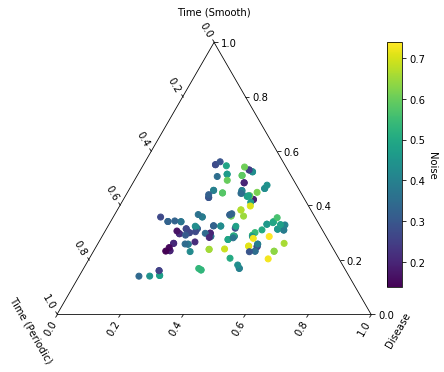

In [23]:
import mpltern
fig = plt.figure(figsize=(12, 5))
ax = plt.subplot(projection='ternary')
# tern_df = (pd.DataFrame(np.concatenate([maps[i]['s2_f'] for i in maps.keys()]),
#             columns = ['time', 'disease', 'person']).
#                    assign(inv_noise = 1/np.concatenate([maps[i]['s2_n'] for i in maps.keys()])))
pc = ax.scatter(map_df.time_smooth,
                map_df.time_period,
                map_df.disease,
                c=map_df.noise)
ax.set_tlabel('Time (Smooth)')
ax.set_llabel('Time (Periodic)')
ax.set_rlabel('Disease')
# ax.tricontourf(t, l, r, v)
cax = ax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax.transAxes)
colorbar = fig.colorbar(pc, cax=cax)
colorbar.set_label('Noise', rotation=270, va='baseline')

plt.show()

In [24]:
np.argsort(-np.concatenate([maps[str(i)]['s2_t'] for i in maps.keys()])[:,0])[:5]

array([ 63,  13, 149,  99,  49])

In [25]:
map_df.iloc[np.argsort(-np.concatenate([maps[str(i)]['s2_t'] for i in maps.keys()])[:,0])[:5],:]

time_smooth  time_period   disease     indiv     noise
63      0.551788     0.127822  0.360312  0.368332  0.246591
13      0.551788     0.127822  0.360312  0.368332  0.246591
149     0.549401     0.188935  0.267732  0.415920  0.491029
99      0.541825     0.211324  0.298838  0.368332  0.466286
49      0.541825     0.211324  0.298838  0.368332  0.466286

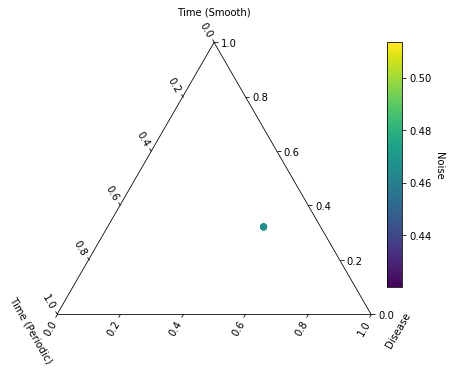

In [134]:
import mpltern
fig = plt.figure(figsize=(12, 5))
ax = plt.subplot(projection='ternary')
# tern_df = (pd.DataFrame(np.concatenate([maps[i]['s2_f'] for i in maps.keys()]),
#             columns = ['time', 'disease', 'person']).
#                    assign(inv_noise = 1/np.concatenate([maps[i]['s2_n'] for i in maps.keys()])))
pc = ax.scatter(map_df.time_smooth[np.argsort(-np.concatenate([maps[str(i)]['s2_d'] for i in maps.keys()]))[:5]],
                map_df.time_period[np.argsort(-np.concatenate([maps[str(i)]['s2_d'] for i in maps.keys()]))[:5]],
                map_df.disease[np.argsort(-np.concatenate([maps[str(i)]['s2_d'] for i in maps.keys()]))[:5]],
                c=map_df.noise[np.argsort(-np.concatenate([maps[str(i)]['s2_d'] for i in maps.keys()]))[:5]])
ax.set_tlabel('Time (Smooth)')
ax.set_llabel('Time (Periodic)')
ax.set_rlabel('Disease')
# ax.tricontourf(t, l, r, v)
cax = ax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax.transAxes)
colorbar = fig.colorbar(pc, cax=cax)
colorbar.set_label('Noise', rotation=270, va='baseline')

plt.show()

In [26]:
# Pull off top disease metabolite
feat_id1 = np.argsort(-np.concatenate([maps[str(i)]['s2_d']
                                      for i in maps.keys()]))[0]
feat_id2 = np.argsort(-np.concatenate([maps[str(i)]['s2_t'] for i in maps.keys()])[:,0])[0]
feat_id3 = np.argsort(-np.concatenate([maps[str(i)]['s2_t'] for i in maps.keys()])[:,0])[1]

In [124]:
import plotly.express as ps

ps.scatter_ternary(map_df, 
                   a = 'time_smooth',
                   b = 'time_period', 
                   c = 'disease',
                   size = 'noise')

# ps.scatter_ternary(map_df.assign(time = map_df.time_smooth + map_df.time_period), 
#                    a = 'time',
#                    b = 'disease', 
#                    c = 'indiv',
#                    size = 'noise')

### Show MAP example

In [150]:
# Fit model for one of the features
feat_id = feat_id3
with pm.Model() as single_feature:
    
    # Exponential length hyperparameter prior
    l_day = pm.Lognormal('l_day', 
                         mu = 0,
                         sigma = 1)
    
    period = pm.Lognormal('period', mu = 0, sigma = 1)
    l_period = pm.Lognormal('l_period', mu = 0, sigma = 1)


    # Exponential length hyperparameter prior on HBI
    c = pm.Normal('c', mu = 0, sigma = 1)
    offset = pm.Lognormal('offset', mu = 0, sigma = 1)
    poly = pm.Poisson('poly', mu = 0.5)
#     l_dis = pm.Lognormal('l_dis', mu=0, sigma=1)
    
#     # Covariance over individuals
#     l_id = pm.Lognormal('l_id', 
#                         mu = 0, 
#                         sigma = 1, 
#                         shape = num_ids)

    # Function variance prior
    s2_t = pm.Lognormal('s2_t', 
                        mu = 0,
                        sigma = 1,
                        shape = 2)
    s2_d = pm.Lognormal('s2_d', 
                        mu = 0,
                        sigma = 1)
#     s2_i = pm.Lognormal('s2_i', 
#                         mu = 0,
#                         sigma = 1)

    # Noise variance prior
    s2_n = pm.Lognormal('s2_n', 
                        mu = 0,
                        sigma = 1)


    # Specify model structure
    gp = pm.gp.Marginal(cov_func = 
          (s2_t[0]*pm.gp.cov.ExpQuad(input_dim = 3,#num_ids+2,
                                    ls = l_day,
                                    active_dims = [0]) + 
          s2_t[1]*pm.gp.cov.Periodic(input_dim = 3,#num_ids+2,
                                     period = period,
                                       ls = l_period,
                                       active_dims = [0]) + 
          s2_d*pm.gp.cov.Polynomial(input_dim = 3,#num_ids+2,
                                        c = c,
                                        d = poly,
                                        offset=offset,
                                        active_dims = [1])
#            s2_d*pm.gp.cov.ExpQuad(input_dim=3,
#                                   ls=l_dis,
#                                  active_dims=[1])
          )* 
               pm.gp.cov.Coregion(input_dim=3,
          active_dims=[2],
           W=np.zeros((n_id, n_id)),
           kappa=np.ones(n_id)))
#           s2_i*pm.gp.cov.ExpQuad(input_dim = num_ids+2,
#                                        ls = l_id,
#                                        active_dims = np.arange(2, 2+num_ids)))
    
    # Learn from observed data
    obs_idx = df.loc[:, mbx.columns[feat_id]].notna()
#     X = df[obs_idx][['days_from_start', 'hbi']+id_list].to_numpy()
    X = df[obs_idx][['days_from_start', 'hbi','id']].to_numpy()#[:, None]
    y = df[obs_idx].loc[:, mbx.columns[feat_id]][:, None].squeeze()
    gp_obs = gp.marginal_likelihood('y',
                                      noise = s2_n,
                                      X = X,
                                      y = y)
    
    mp = pm.find_MAP()

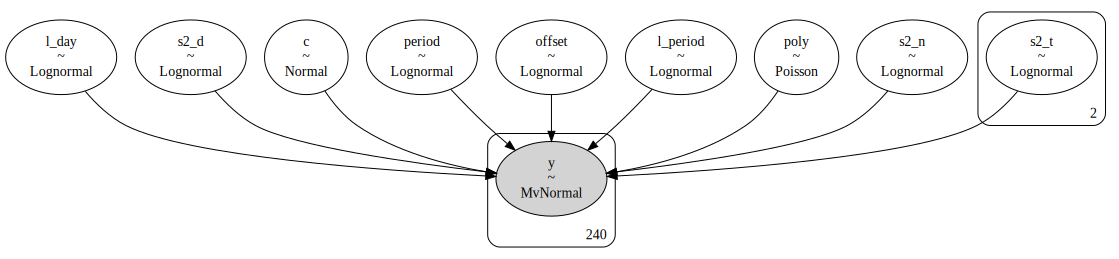

In [135]:
pm.model_to_graphviz(single_feature)

In [136]:
mp

{'l_day_log__': array(-0.35683884),
 'period_log__': array(0.25863156),
 'l_period_log__': array(-1.21746263),
 'c': array(0.),
 'offset_log__': array(-0.99999707),
 'poly': array(0),
 's2_t_log__': array([-1.93049539, -0.86037098]),
 's2_d_log__': array(-1.37493134),
 's2_n_log__': array(-0.58786201),
 'l_day': array(0.69988528),
 'period': array(1.29515653),
 'l_period': array(0.29598023),
 'offset': array(0.36788052),
 's2_t': array([0.14507631, 0.42300513]),
 's2_d': array(0.25285696),
 's2_n': array(0.5555137)}

In [137]:
# Predict values across time, assume we are looking at the first id
# X_new = np.vstack([np.linspace(-3, 3, 200), 
#                    np.linspace(-3, 3, 200), 
#                    np.repeat(1, 200),
#                    np.zeros(shape = (num_ids-1, 200))]).T
x1, x2 = np.meshgrid(np.linspace(-3,3,11),#0, 1000, 20), 
                         np.linspace(-6,6,11))#0, 20, 5))
X_new = np.vstack([x1.ravel(), 
                   x2.ravel(),
                   np.repeat(0, len(x1.ravel())),
                   np.zeros(shape = (num_ids-1, len(x1.ravel())))]).T

X_new_time = np.vstack([np.linspace(-3, 3, 100), 
                   np.repeat(0, 100), 
                   np.repeat(0, 100)]).T
#                    np.zeros(shape = (num_ids-1, 100))]).T
X_new_dis = np.vstack([np.repeat(0, 100), 
                   np.linspace(-6, 6, 100),
                   np.repeat(0, 100)]).T#,
#                    np.zeros(shape = (num_ids-1, 100))]).T

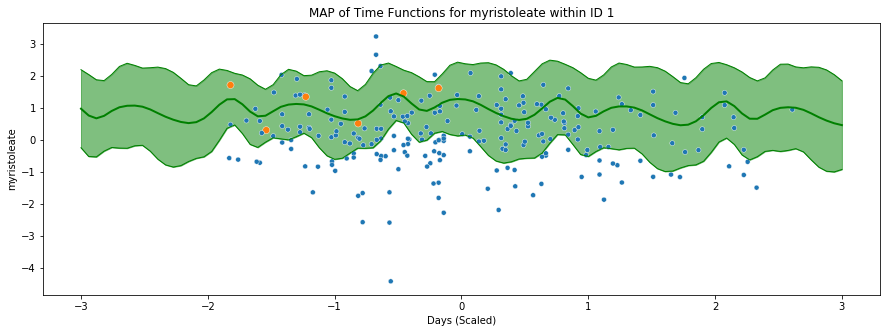

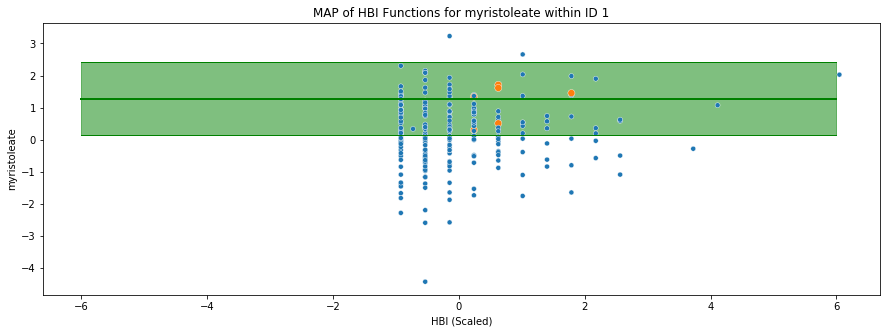

In [138]:
# Plot posterior from MAP 
mu, var = gp.predict(X_new_time, point=mp, diag=True)
sd = np.sqrt(var)


# Set up figure
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()

# Plot mean +/- 2 SD
plt.plot(X_new_time[:,0], mu, "g", lw=2)#, label="mean and 2σ region")
plt.plot(X_new_time[:,0], mu + 2 * sd, "g", lw=1)
plt.plot(X_new_time[:,0], mu - 2 * sd, "g", lw=1)
plt.fill_between(X_new_time[:,0].flatten(), mu - 2 * sd, mu + 2 * sd, color="g", alpha=0.5)
# plt.title('MAP Function for One Individual');
# ax.set_ylabel('Metabolite')
ax.set_xlabel('Days (Scaled)')
ax.set_title('MAP of Time Functions for {} within ID 1'.format(mbx_list[feat_id]))
# Overlay observed data
sns.scatterplot(x = df.days_from_start,#df[df.id_C3001==1]['days_from_start'],
                y = df[mbx_list[feat_id]],#df[df.id_C3001==1].iloc[:,feat_id],
                hue=df.id==0,
                size=df.id==0,
                sizes=[25,50],
                legend=False)#,
#                 hue = df.id_C3002, legend=False, 
#                 alpha=0.5);

## Now for disease status
mu, var = gp.predict(X_new_dis, point=mp, diag=True)
sd = np.sqrt(var)

# Set up figure
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()

# Plot mean +/- 2 SD
plt.plot(X_new_dis[:,1], mu, "g", lw=2)#, label="mean and 2σ region")
plt.plot(X_new_dis[:,1], mu + 2 * sd, "g", lw=1)
plt.plot(X_new_dis[:,1], mu - 2 * sd, "g", lw=1)
plt.fill_between(X_new_dis[:,1].flatten(), mu - 2 * sd, mu + 2 * sd, color="g", alpha=0.5)
ax.set_title('MAP of HBI Functions for {} within ID 1'.format(mbx_list[feat_id]))
ax.set_xlabel('HBI (Scaled)')
sns.scatterplot(x = df.hbi,#df[df.id_C3001==1]['days_from_start'],
                y = df[mbx_list[feat_id]],#df[df.id_C3001==1].iloc[:,feat_id],
                hue=df.id==0,
                size=df.id==0,
                sizes=[25,50],
                legend=False)#,
#                 alpha=0.5)


### Run sampling inference on MAP example

In [156]:
# Sample from posterior distribution for single feature

with single_feature:
    step1 = pm.NUTS(target_accept=0.9)
    step2 = pm.Metropolis([poly])
    
    feat_trace = pm.sample(5000,
                  init = 'advi_map',
                           step=[step1, step2],
                  random_seed = 1,
                  tune = 2000,
                  chains = 2,
                  cores = 2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [s2_n, s2_d, s2_t, offset, c, l_period, period, l_day]
>Metropolis: [poly]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 4743 seconds.
There were 236 divergences after tuning. Increase `target_accept` or reparameterize.
There were 266 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7615490909107102, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
c        -0.061  1.000  -1.886    1.761      0.049    0.035     418.0   418.0   
poly      0.025  0.156   0.000    0.000      0.004    0.003    1283.0  1283.0   
l_day     0.852  1.629   0.024    3.268      0.061    0.043     709.0   709.0   
period    1.325  1.507   0.056    3.074      0.032    0.023    2160.0  2160.0   
l_period  1.185  1.853   0.034    3.631      0.045    0.032    1722.0  1722.0   
offset    1.616  2.074   0.042    4.679      0.040    0.029    2635.0  2635.0   
s2_t[0]   0.371  0.204   0.053    0.709      0.012    0.009     283.0   283.0   
s2_t[1]   0.317  0.165   0.049    0.628      0.011    0.009     231.0   183.0   
s2_d      0.272  0.132   0.040    0.505      0.004    0.003    1120.0  1120.0   
s2_n      0.462  0.211   0.088    0.804      0.008    0.006     669.0   669.0   

          ess_bulk  ess_tail  r_hat  
c            427.0    1346.0   1.00  
poly        1283.0    1283.0   1.00  
l_day        334.0    1659.0   1.01  
period       766.0     506.0   1.00  
l_period     477.0     886.0   1.01  
offset      2612.0    3305.0   1.00  
s2_t[0]      246.0     246.0   1.01  
s2_t[1]      318.0     126.0   1.01  
s2_d        1029.0    1149.0   1.00  
s2_n         709.0    1258.0   1.00

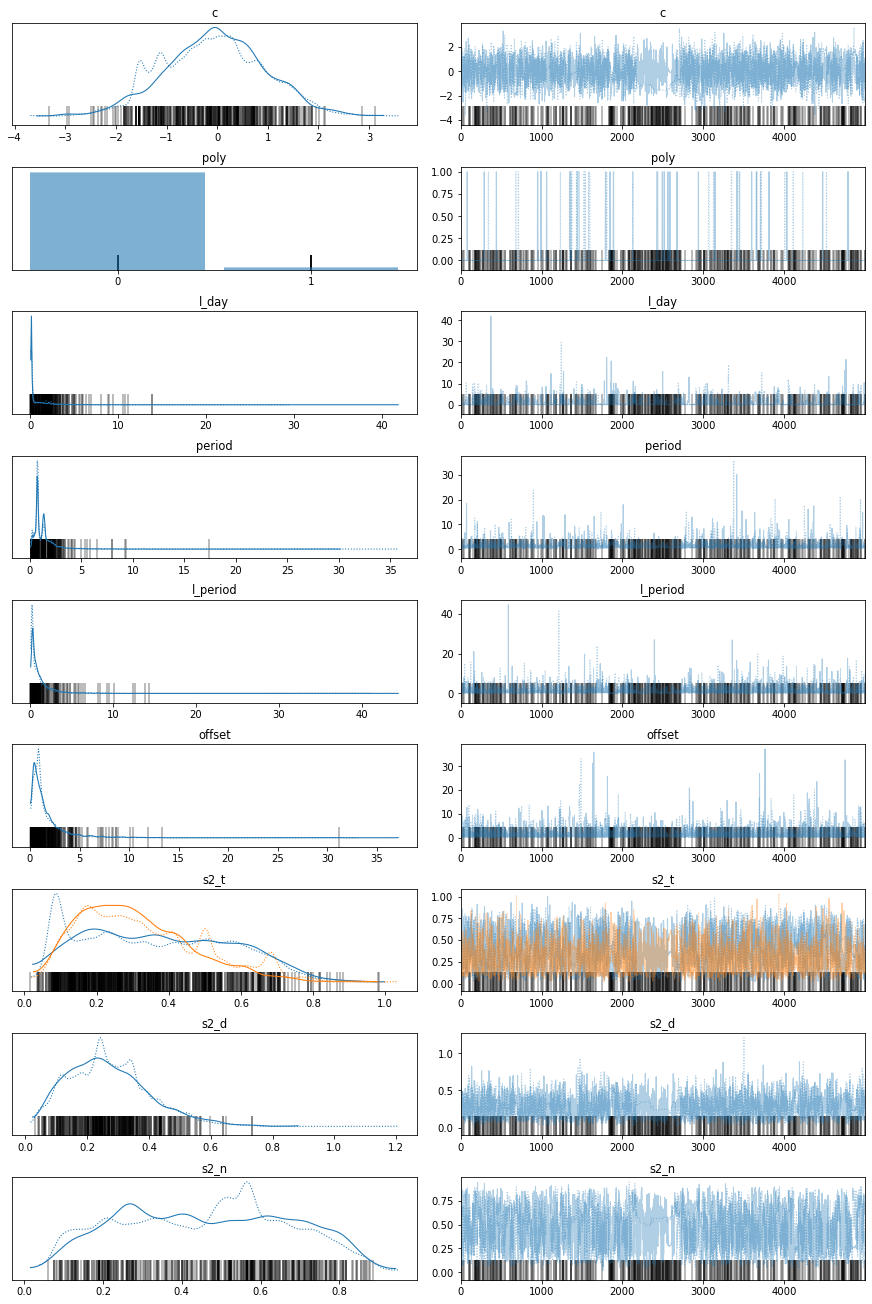

In [157]:
pm.traceplot(feat_trace)
pm.summary(feat_trace)#, var_names=['s2_f', 's2_n'])

/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


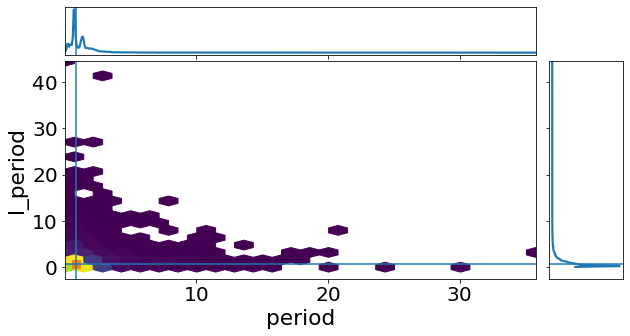

In [158]:
import arviz as az

az.plot_pair(feat_trace,
             var_names=['period', 'l_period'],
             marginals=True,
             point_estimate='median',
             kind='hexbin',
             figsize=(10,5));

/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


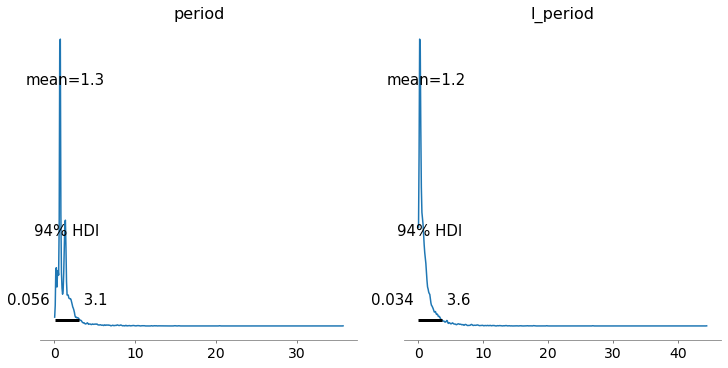

In [160]:
az.plot_posterior(feat_trace,
             var_names=['period', 'l_period'],
             figsize=(10,5));

/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


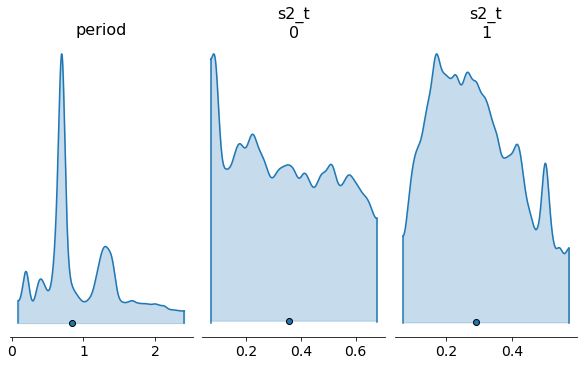

In [166]:
az.plot_density(
    feat_trace,
    var_names=["period", 's2_t'],
    hdi_prob = 0.90,
    shade = 0.25,
    point_estimate="median",
    figsize=(8, 5),
);

/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


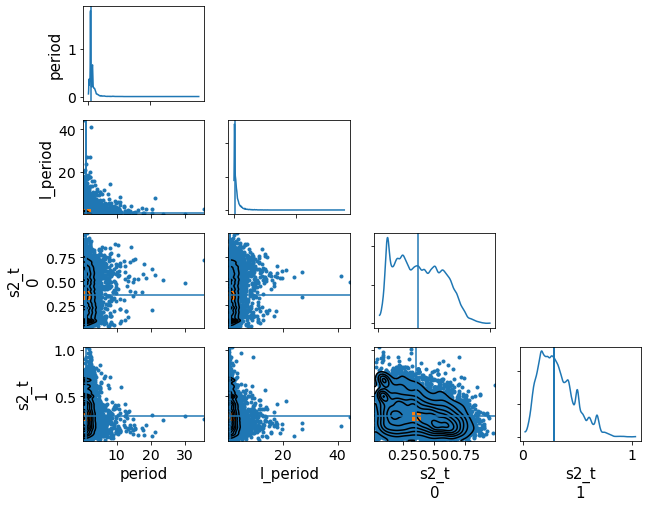

In [159]:
import arviz as az

ax = az.plot_pair(
    feat_trace,
    var_names=["period", "l_period", "s2_t"],
    kind=["scatter", "kde"],
    kde_kwargs={"fill_last": False},
    marginals=True,
#     coords=coords,
    point_estimate="median",
    figsize=(10, 8),
)

In [91]:
# add the GP conditional to the model, given the new X values
with single_feature:
    # First get the conditional function values given posterior
    f_pred = gp.conditional('f_pred', X_new_time)
    
    # Now get the predictive distribution
    pred_samples = pm.sample_posterior_predictive(feat_trace, 
                                                  var_names = ['f_pred'],
                                                  random_seed = 1)
    
    # Now get disease conditional
    f_pred_d = gp.conditional('f_pred_d', X_new_dis)
    pred_samples_d = pm.sample_posterior_predictive(feat_trace, 
                                                  var_names = ['f_pred_d'],
                                                  random_seed = 1)
    # Get predictive distribution
    
#     # First get the conditional observation values given posterior
#     y_pred = gp.conditional('y_pred', X_new_time, pred_noise = True)
    
#     # Now get the predictive distribution
#     y_samples = pm.sample_posterior_predictive(feat_trace, 
#                                                var_names = ['y_pred'],
#                                                random_seed = 1)

Text(0.5, 1, 'Time Covariance')

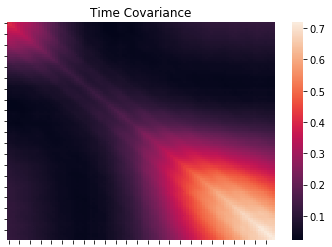

In [117]:
g = sns.heatmap(np.cov(pred_samples['f_pred'], rowvar=False))
g.set_xticklabels('')
g.set_yticklabels('')
g.set_title('Time Covariance')

Text(0.5, 1, 'Disease Covariance')

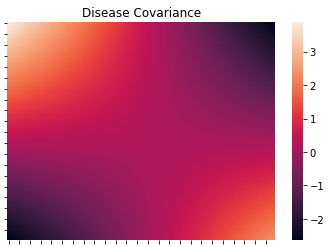

In [118]:
g = sns.heatmap(np.cov(pred_samples_d['f_pred_d'], rowvar=False))
g.set_xticklabels('')
g.set_yticklabels('')
g.set_title('Disease Covariance')

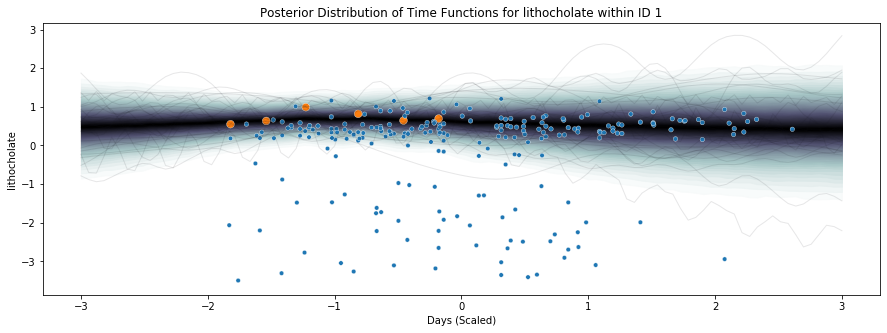

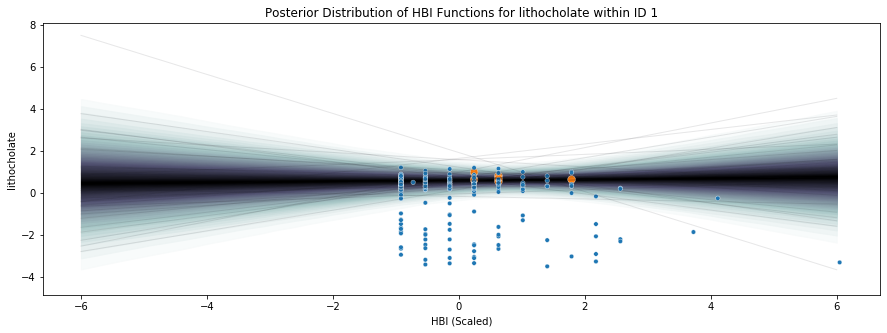

In [95]:
# Plotting 
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()
plot_gp_dist(ax, 
             pred_samples["f_pred"], 
             X_new_time[:,0],
             palette='bone_r')
# ax.set_ylabel('Metabolite')
ax.set_xlabel('Days (Scaled)')
ax.set_title('Posterior Distribution of Time Functions for {} within ID 1'.format(mbx_list[feat_id]))
# Overlay observed data
sns.scatterplot(#data = df,
                #x = 'days_from_start',
                #y = '12.13-diHOME',
                x = df.days_from_start,
                y = df[mbx_list[feat_id]],
#                 s = 25,
                size=df.id==0,
                sizes=[20,60],
                hue=df.id==0,
                legend=False);

# # Specify labels and axes
# plt.xlabel("Time in days from start")
# # plt.ylim([-6, 6])
# # plt.xlim([-3, 3])
# plt.title("Posterior distribution over $f(x)$")
# plt.legend();

fig = plt.figure(figsize=(15, 5))
ax = fig.gca()
plot_gp_dist(ax, 
             pred_samples_d["f_pred_d"], 
             X_new_dis[:,1],
             palette='bone_r')
ax.set_xlabel('HBI (Scaled)')
ax.set_title('Posterior Distribution of HBI Functions for {} within ID 1'.format(mbx_list[feat_id]))
# Overlay observed data
sns.scatterplot(#data = df,
                #x = 'days_from_start',
                #y = '12.13-diHOME',
                x = df.hbi,
                y = df[mbx_list[feat_id]],
#                 s = 25,
                size=df.id==0,
                sizes=[20,60],
                hue=df.id==0,
                legend=False);

# # Specify labels and axes
# plt.xlabel("Time in days from start")
# # plt.ylim([-6, 6])
# # plt.xlim([-3, 3])
# plt.title("Posterior distribution over $f(x)$")
# plt.legend();

# # Plot for disease status
# fig = plt.figure(figsize=(15, 5))
# ax = fig.gca()
# plot_gp_dist(ax, 
#              pred_samples["f_pred"][:,X_new[:,0]==3], 
#              X_new[X_new[:,0]==3,1])

# # Overlay observed data
# sns.scatterplot(#data = df,
#                 #x = 'days_from_start',
#                 #y = '12.13-diHOME',
#                 x = df.hbi,
#                 y = df.iloc[:,feat_id],
#                 s = 50);

# # Specify labels and axes
# plt.xlabel("HBI")
# # plt.ylim([-6, 6])
# # plt.xlim([-3, 3])
# plt.title("Posterior distribution over $f(x)$")
# plt.legend();

No handles with labels found to put in legend.
No handles with labels found to put in legend.


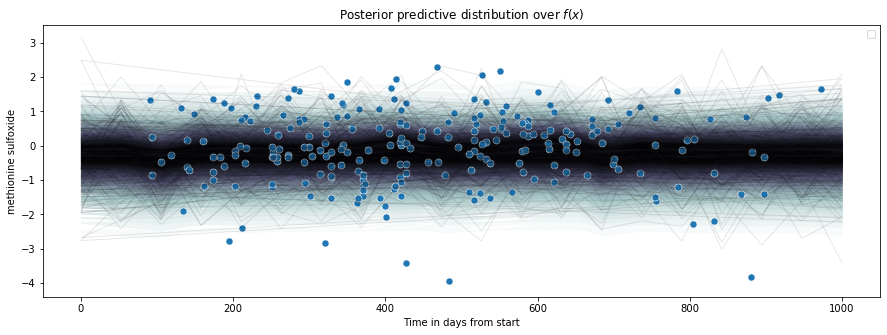

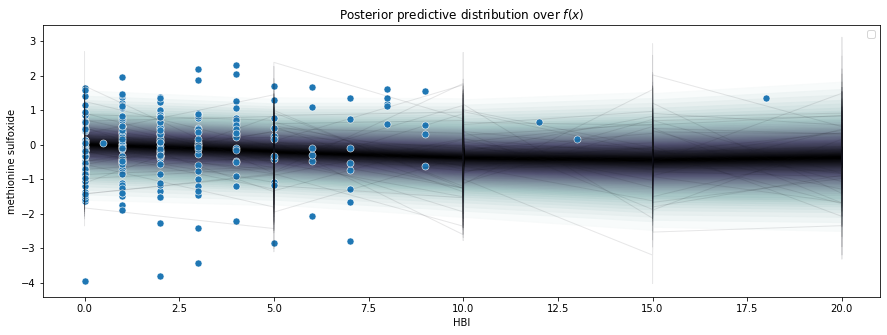

In [136]:
# Plotting PPD for observations (include noise)
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()
plot_gp_dist(ax, 
             y_samples['y_pred'], 
             X_new[:,0],
             palette = 'bone_r')

# Overlay observed data
sns.scatterplot(#data = df,
                #x = 'days_from_start',
                #y = '12.13-diHOME',
                x = df.days_from_start,
                y = df.iloc[:,feat_id],
                s = 50);

# Specify labels and axes
plt.xlabel("Time in days from start")
# plt.ylim([-6, 6])
# plt.xlim([-3, 3])
plt.title("Posterior predictive distribution over $f(x)$")
plt.legend();

# HBI

# Plotting PPD for observations (include noise)
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()
plot_gp_dist(ax, 
             y_samples['y_pred'], 
             X_new[:,1],
             palette = 'bone_r')

# Overlay observed data
sns.scatterplot(#data = df,
                #x = 'days_from_start',
                #y = '12.13-diHOME',
                x = df.hbi,
                y = df.iloc[:,feat_id],
                s = 50);

# Specify labels and axes
plt.xlabel("HBI")
# plt.ylim([-6, 6])
# plt.xlim([-3, 3])
plt.title("Posterior predictive distribution over $f(x)$")
plt.legend();

In [181]:
def closed_figure(mu, sd, sd_p, X, X_obs, Y_obs):
    # Set up figure
    fig = plt.figure(figsize=(8, 5))
    ax = fig.gca()
    
    # Plot mean +/- 2 SD
    plt.plot(X, mu, "g", lw=2, label="predicted mean")
    plt.plot(X, mu + 2 * sd, "g", lw=1)
    plt.plot(X, mu - 2 * sd, "g", lw=1)
    plt.fill_between(X, mu - 2 * sd, mu + 2 * sd, color="g", alpha=0.5)

    # plt.plot(X_new, mu, 'r', lw = 2, label = 'predicted values')
    plt.plot(X, mu + 2*sd_p, 'r', lw = 1, label = 'predicted values')
    plt.plot(X, mu - 2*sd_p, 'r', lw = 1)
    plt.fill_between(X, 
                     mu - 2*sd_p, 
                     mu + 2*sd_p, 
                     color = 'r', 
                     alpha = 0.25)

    # Overlay observed data
    sns.scatterplot(x = X_obs,
                    y = Y_obs,
                    s = 50);

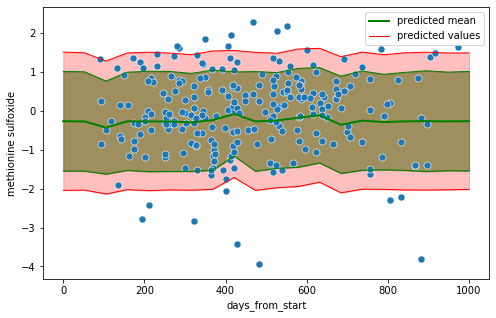

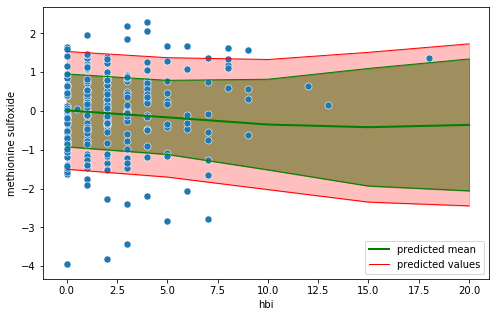

In [184]:
fig_data = pd.DataFrame(np.array([pred_samples['f_pred'].mean(axis = 0),
                pred_samples['f_pred'].std(axis = 0),
                y_samples['y_pred'].std(axis = 0),
                X_new[:,0]]).T,
            columns = ['mean', 'sd', 'sd_p', 'time']).groupby(['time']).mean().reset_index()

closed_figure(mu = fig_data['mean'],
              sd = fig_data['sd'],
              sd_p = fig_data['sd_p'],
              X = fig_data['time'],
              X_obs = df.days_from_start,
              Y_obs = df.iloc[:,feat_id])

fig_data = pd.DataFrame(np.array([pred_samples['f_pred'].mean(axis = 0),
                pred_samples['f_pred'].std(axis = 0),
                y_samples['y_pred'].std(axis = 0),
                X_new[:,1]]).T,
            columns = ['mean', 'sd', 'sd_p', 'hbi']).groupby(['hbi']).mean().reset_index()

closed_figure(mu = fig_data['mean'],
              sd = fig_data['sd'],
              sd_p = fig_data['sd_p'],
              X = fig_data['hbi'],
              X_obs = df.hbi,
              Y_obs = df.iloc[:,feat_id])

In [102]:
# Function predictions from MAP estimates
# X_new = np.linspace(-3, 3, 200)[:, None]
# X_new = np.vstack([np.linspace(0, 1000, 200), 
#                    np.repeat(0, 200),
#                    np.repeat(1, 200),
#                    np.zeros(shape = (num_ids-1, 200))]).T
map_output = {}
for i in gps:
    if int(i) > 5:
        break
    print('Currently predicting function values for {}'.format(i))
    map_output[str(i)] = {}
    map_output[str(i)]['mu'], map_output[str(i)]['var'] = gps[str(i)]['model'].predict(X_new,
                                                          point = mp,
                                                          diag = True)
    
    map_output[str(i)]['mu_p'], map_output[str(i)]['var_p'] = gps[str(i)]['model'].predict(X_new,
                                                          point = mp,
                                                          pred_noise = True,
                                                          diag = True)
    
    
# # Plot posterior from MAP 
# mu, var = gp.predict(X_new, 
#                      point = mp, 
#                      diag = True)
# sd = np.sqrt(var)

# # Calculate observed level params
# mu_p, var_p = gp.predict(X_new, 
#                          point = mp,
# #                          diag = True,
#                          pred_noise = True)
# sd_p = np.sqrt(var_p)

NameError: name 'gps' is not defined

In [132]:
# Gather prediction values
X_new_map = pd.concat([pd.DataFrame(X_new).rename(columns = 
                                                  pd.Series(['time', 'hbi'] + 
                                                            ['id_'+str(i) for i in range(num_ids)])),
                       pd.DataFrame([map_output[x]['mu'] for x in map_output]).T.rename(columns = 
                                                                 pd.Series([m+'_mu' for m in mbx_list.values])),
                       pd.DataFrame([map_output[x]['var'] for x in map_output]).T.rename(columns = 
                                                                 pd.Series([m+'_var' for m in mbx_list.values])),
                       pd.DataFrame([map_output[x]['var_p'] for x in map_output]).T.rename(columns = 
                                                                 pd.Series([m+'_var_p' for m in mbx_list.values]))],
                      axis = 1)

In [133]:
X_new_map

time   hbi  id_0  id_1  id_2  id_3  id_4  id_5  id_6  id_7  ...  \
0      0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1     52.631579   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2    105.263158   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3    157.894737   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4    210.526316   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
..          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
95   789.473684  20.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
96   842.105263  20.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
97   894.736842  20.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
98   947.368421  20.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
99  1000.000000  20.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

    caproate_var  heptanoate_var  hydrocinnamate_var  mandelate_var  \
0       0.089816        0.217103            0.098503       0.202544   
1       0.089816        0.217103            0.098503       0.202544   
2       0.084147        0.217103            0.096010       0.183753   
3       0.089816        0.217103            0.098503       0.202544   
4       0.083346        0.211449            0.097664       0.197341   
..           ...             ...                 ...            ...   
95      0.267600        0.486764            0.339520       0.358199   
96      0.272194        0.486764            0.340338       0.359443   
97      0.272189        0.486764            0.340338       0.359443   
98      0.272194        0.486764            0.340338       0.359443   
99      0.272194        0.486764            0.340338       0.359443   

    12.13-diHOME_var_p  9.10-diHOME_var_p  caproate_var_p  heptanoate_var_p  \
0             0.538708           0.528911        0.366679          0.412616   
1             0.538708           0.528911        0.366679          0.412616   
2             0.536295           0.527379        0.361009          0.412616   
3             0.538708           0.528911        0.366678          0.412616   
4             0.538325           0.527075        0.360208          0.406962   
..                 ...                ...             ...               ...   
95            0.673767           0.743370        0.544462          0.682278   
96            0.673820           0.744890        0.549057          0.682278   
97            0.673820           0.744890        0.549051          0.682278   
98            0.673820           0.744890        0.549057          0.682278   
99            0.673820           0.744890        0.549057          0.682278   

    hydrocinnamate_var_p  mandelate_var_p  
0               0.485350         0.776998  
1               0.485350         0.776998  
2               0.482857         0.758207  
3               0.485350         0.776998  
4               0.484511         0.771795  
..                   ...              ...  
95              0.726367         0.932653  
96              0.727185         0.933897  
97              0.727185         0.933897  
98              0.727185         0.933897  
99              0.727185         0.933897  

[100 rows x 70 columns]

In [202]:
import plotly.graph_objects as go

fig = go.Figure(data =
    go.Contour(
        z = pred_samples['f_pred'].mean(axis=0).reshape(5,20),
        x = np.unique(x1),
        y = np.unique(x2),
        colorscale = 'Turbo'#'Aggrnyl'
    ),
               layout = go.Layout(
               title = 'Mean of Feature',
               yaxis_title = 'HBI',
               xaxis_title = 'Time'))
fig.show()

fig = go.Figure(data =
    go.Contour(
        z = pred_samples['f_pred'].std(axis=0).reshape(5,20),
        x = np.unique(x1),
        y = np.unique(x2),
        colorscale = 'Turbo'#'Aggrnyl'
    ),
               layout = go.Layout(
               title = 'Standard Deviation of Feature',
               yaxis_title = 'HBI',
               xaxis_title = 'Time'))
fig.show()

In [ ]:
# import plotly.graph_objs as go
# from plotly.subplots import make_subplots

# max_row = 3
# max_col = 2
# fig = make_subplots(rows = max_row, cols = max_col)

# # fig.add_trace(go.Contour(z=z, showscale=False), 1, 1)
# # fig.add_trace(go.Contour(z=z, showscale=False), 1, 2)
# # fig.add_trace(go.Heatmap(z=z, showscale=False), 2, 1)
# # fig.add_trace(go.Heatmap(z=z, showscale=False), 2, 2)

# for i in range(len(gps)):
#     r = i+1
#     c = i+1
#     fig.add_trace(go.Contour(
#         z = X_new_map_time_agg[[c for c in X_new_map_time_agg if c.endswith('_mu')]].iloc[:,i].reshape(5,20),
#         x = np.unique(x1),
#         y = np.unique(x2),
#         colorscale = 'Aggrnyl'
#     ), i+1, )

# # fig['layout']['yaxis1'].update(title='Contour map')
# # fig['layout']['yaxis3'].update(title='Heatmap')

# fig.show()

## Clustering

In [67]:
# Build out cluster features
clust_feats = (pd.DataFrame(
    np.concatenate(
        [np.concatenate(
            # Pull out 1D arrays from MAP object
            (np.array([maps[x]['l_day'],
                       maps[x]['l_hbi'],
                       np.mean(maps[x]['l_id'], axis = 1),
                       maps[x]['s2_n']]).T,
             maps[x]['s2_f']),
             axis = 1) for x in maps.keys()], 
        axis = 0),
    # Specify column names
  columns = ['l_day','l_hbi','avg_l_id',
             's2_noise', 's2_day', 's2_hbi', 
             's2_id']))

clust_feats.head()

l_day     l_hbi  avg_l_id  s2_noise    s2_day    s2_hbi     s2_id
0  0.366026  0.411503  0.564377  0.682197  0.035167  0.131649  0.165063
1  0.377828  0.938613  0.565108  0.653063  0.045856  0.205964  0.177219
2  0.678340  2.344168  0.679508  0.526172  0.048224  0.203233  0.250672
3  0.373815  0.637103  0.550021  0.447231  0.132086  0.220762  0.342504
4  0.320019  1.290974  0.658652  0.621969  0.048513  0.227944  0.285376

In [252]:
from sklearn.datasets import make_blobs

In [283]:
clust_feats = make_blobs(n_samples = 100,
                         centers = 10,
                                          n_features = 7,
                                          cluster_std = 5,
                                          random_state = 1)

clust_feats = pd.DataFrame(clust_feats[0])

In [284]:
clust_feats.head()

0         1          2         3          4          5         6
0  -2.003302  6.587563  -4.006096 -5.084570   6.471675   1.444625  2.886437
1 -16.112006 -5.394093  -9.907510 -3.278981 -12.787838   3.742424  4.382394
2 -10.222358  4.111921   8.528673 -3.469738   2.888601  10.209544 -5.749021
3  -7.183318  6.685555 -12.702637 -4.242949   2.025014   9.503105  1.460678
4   4.377119  1.855995   2.942665  0.638886   5.269934   7.381436  6.714149

In [289]:
# Dirichlet clustering
from theano import tensor as tt

F = 7
K = 30
N = clust_feats.shape[0]
init_means = np.mean(clust_feats, axis = 0)
init_cov = np.cov(clust_feats, rowvar = False)
# np.random.seed(9102)

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

with pm.Model() as clustering:
    # Dirichlet prior mixing parameter
    alpha = pm.Gamma("alpha", 1.0, 1.0)
    beta = pm.Beta("beta", 1, alpha, shape = K)
    w = pm.Deterministic("w", stick_breaking(beta))
  
    # Cluster info
#     tau = pm.Gamma('tau', 1., 1., shape = (7,K))
#     lambda_ = pm.Uniform('lambda', 0, 5, shape = (7, K))
#     mu = pm.Normal('mu', 0, tau = lambda_*tau, shape = (7, K))

    dists = [pm.MvNormal('c'+str(k+1), 
                                  mu = np.ones(init_means.shape),#np.random.beta(1,1,init_means.shape), 
                                  cov = np.eye(F),#np.random.beta(1,1,init_cov.shape),
                                  shape = F).distribution
                      for k in range(K)]

#     dists = pm.MvNormal('c',
#                         mu = np.ones(F),
#                         cov = np.eye(F),
#                         shape = (K, F)).distribution
    obs = pm.Mixture('obs', 
                     w,
                     comp_dists = dists,
                     observed = clust_feats)#,
#                      shape = (N, F))
    
    

In [291]:
with clustering:
    clust_trace = pm.sample(2000,
                           cores = 1,
                           step = pm.Metropolis(),
#                            init = 'advi_map',
#                            n_init = 5000,
                           random_seed = 1,
#                            target_accept = 0.9,
                           tune = 500,
                           chains = 2)


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [c30]
>Metropolis: [c29]
>Metropolis: [c28]
>Metropolis: [c27]
>Metropolis: [c26]
>Metropolis: [c25]
>Metropolis: [c24]
>Metropolis: [c23]
>Metropolis: [c22]
>Metropolis: [c21]
>Metropolis: [c20]
>Metropolis: [c19]
>Metropolis: [c18]
>Metropolis: [c17]
>Metropolis: [c16]
>Metropolis: [c15]
>Metropolis: [c14]
>Metropolis: [c13]
>Metropolis: [c12]
>Metropolis: [c11]
>Metropolis: [c10]
>Metropolis: [c9]
>Metropolis: [c8]
>Metropolis: [c7]
>Metropolis: [c6]
>Metropolis: [c5]
>Metropolis: [c4]
>Metropolis: [c3]
>Metropolis: [c2]
>Metropolis: [c1]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 238 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


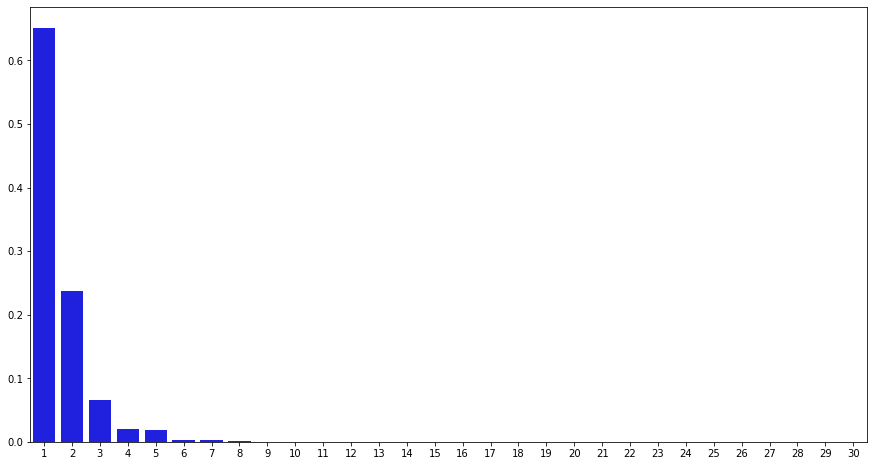

In [292]:
# Mixing plot to figure out the number of clusters
plt.figure(figsize = (15, 8))
sns.barplot(y = clust_trace['w'].mean(axis = 0),
            x = np.arange(K)+1,
           color = 'blue');

In [293]:
num_clusts = np.where(clust_trace['w'].mean(axis = 0) < 0.05)[0][0] + 1
print('Retain {} clusters, which maintain 95% of coverage.'.format(num_clusts))

Retain 4 clusters, which maintain 95% of coverage.


In [294]:
pm.summary(clust_trace, var_names=['alpha']+['c'+str(i+1) for i in np.arange(5)])

/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha  0.601  0.361   0.185    1.263      0.192    0.149       4.0     4.0   
c1[0]  1.064  0.932  -0.863    2.601      0.063    0.045     216.0   216.0   
c1[1]  0.946  1.095  -0.974    2.960      0.091    0.065     146.0   143.0   
c1[2]  0.932  0.967  -0.837    2.616      0.074    0.052     171.0   171.0   
c1[3]  1.098  0.916  -0.570    2.842      0.080    0.057     132.0   132.0   
c1[4]  1.041  1.010  -0.797    2.905      0.072    0.051     198.0   198.0   
c1[5]  0.993  0.988  -0.941    2.879      0.079    0.056     156.0   156.0   
c1[6]  0.863  1.056  -1.250    2.553      0.083    0.059     162.0   162.0   
c2[0]  1.087  1.006  -1.014    2.805      0.073    0.051     192.0   192.0   
c2[1]  0.948  1.000  -0.913    2.763      0.100    0.071      99.0    99.0   
c2[2]  0.964  0.991  -0.994    2.731      0.070    0.053     203.0   176.0   
c2[3]  0.935  1.024  -0.933    2.971      0.086    0.061     143.0   143.0   
c2[4]  1.020  1.059  -1.023    2.937      0.083    0.059     163.0   163.0   
c2[5]  0.966  0.954  -0.712    2.838      0.062    0.044     239.0   239.0   
c2[6]  1.175  0.966  -0.716    3.011      0.066    0.047     212.0   212.0   
c3[0]  0.935  1.005  -1.003    2.856      0.073    0.051     192.0   192.0   
c3[1]  0.972  1.014  -0.892    2.812      0.081    0.059     158.0   150.0   
c3[2]  1.002  0.990  -0.775    2.873      0.081    0.060     148.0   137.0   
c3[3]  1.002  0.978  -0.731    2.930      0.066    0.047     218.0   218.0   
c3[4]  0.961  1.040  -1.096    2.823      0.086    0.061     146.0   146.0   
c3[5]  0.925  0.931  -0.718    2.720      0.066    0.046     201.0   201.0   
c3[6]  0.796  1.016  -1.051    2.698      0.072    0.051     199.0   199.0   
c4[0]  1.047  0.975  -0.784    2.777      0.063    0.045     239.0   239.0   
c4[1]  0.955  1.038  -0.950    2.846      0.075    0.063     190.0   135.0   
c4[2]  1.127  1.004  -0.700    3.011      0.085    0.060     139.0   139.0   
c4[3]  0.995  0.966  -0.860    2.710      0.065    0.046     222.0   222.0   
c4[4]  0.825  0.968  -1.174    2.494      0.070    0.050     189.0   189.0   
c4[5]  0.948  1.037  -1.286    2.646      0.081    0.057     164.0   164.0   
c4[6]  0.952  1.030  -0.946    2.886      0.072    0.051     202.0   202.0   
c5[0]  1.045  0.984  -0.711    2.887      0.073    0.052     182.0   182.0   
c5[1]  1.016  1.028  -1.003    2.821      0.080    0.057     165.0   165.0   
c5[2]  0.926  1.000  -0.879    2.733      0.075    0.054     176.0   172.0   
c5[3]  1.020  0.993  -0.680    3.008      0.073    0.052     186.0   186.0   
c5[4]  0.983  1.000  -0.856    2.801      0.067    0.047     223.0   223.0   
c5[5]  1.131  1.055  -0.950    2.991      0.096    0.069     122.0   118.0   
c5[6]  1.035  1.007  -0.750    2.958      0.079    0.056     164.0   164.0   

       ess_bulk  ess_tail  r_hat  
alpha       3.0      29.0   1.70  
c1[0]     221.0     314.0   1.01  
c1[1]     148.0     209.0   1.02  
c1[2]     172.0     289.0   1.02  
c1[3]     132.0     320.0   1.02  
c1[4]     201.0     248.0   1.02  
c1[5]     157.0     145.0   1.00  
c1[6]     162.0     233.0   1.01  
c2[0]     195.0     288.0   1.02  
c2[1]     101.0     197.0   1.03  
c2[2]     206.0     288.0   1.01  
c2[3]     142.0     272.0   1.01  
c2[4]     163.0     287.0   1.01  
c2[5]     239.0     323.0   1.01  
c2[6]     215.0     276.0   1.01  
c3[0]     194.0     288.0   1.01  
c3[1]     160.0     181.0   1.01  
c3[2]     148.0     211.0   1.01  
c3[3]     216.0     408.0   1.01  
c3[4]     145.0     271.0   1.01  
c3[5]     202.0     284.0   1.01  
c3[6]     200.0     294.0   1.04  
c4[0]     240.0     384.0   1.01  
c4[1]     187.0     232.0   1.01  
c4[2]     139.0     310.0   1.01  
c4[3]     223.0     339.0   1.01  
c4[4]     189.0     398.0   1.02  
c4[5]     166.0     304.0   1.01  
c4[6]     203.0     280.0   1.01  
c5[0]     183.0     333.0   1.00  
c5[1]     164.0     299.0   1.01  
c

/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



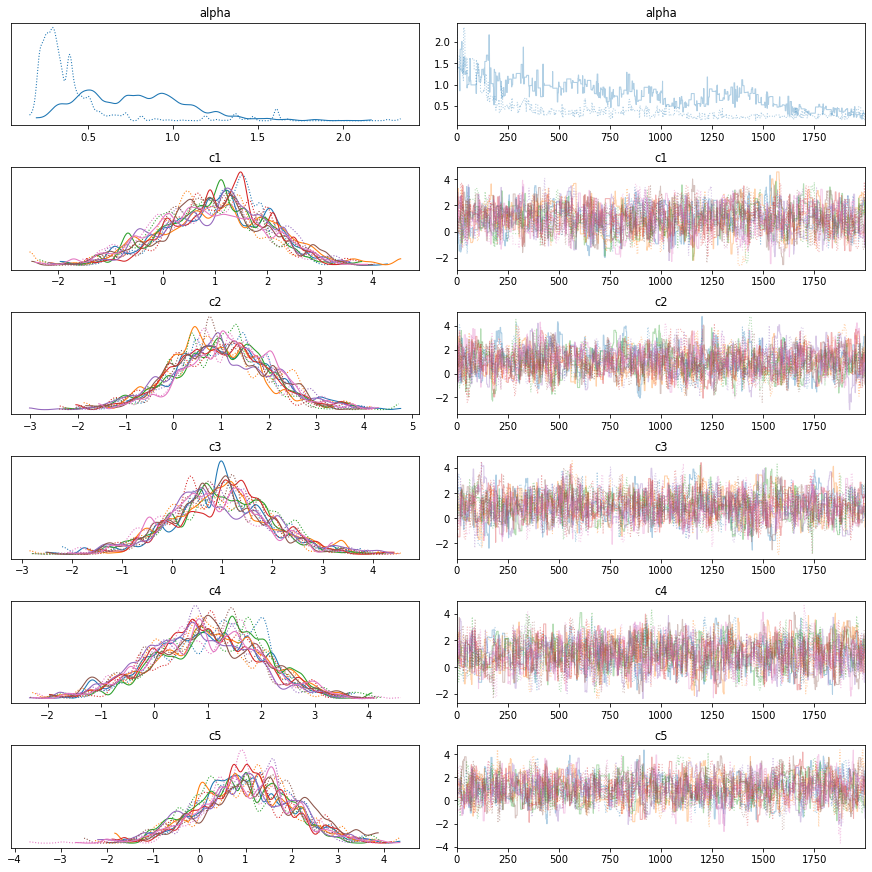

In [295]:
pm.traceplot(clust_trace, var_names=['alpha']+['c'+str(i+1) for i in np.arange(5)]);

## Cluster Level Inference

In [280]:
clust_trace['c1'].mean(axis=0)

array([0.85843245, 0.81139202, 1.07958837, 1.12935703, 0.82557555,
       1.13475591, 0.96645806])

In [281]:
clust_trace['c2'].mean(axis=0)

array([1.09553503, 1.04206302, 1.12219092, 1.03916146, 0.94781404,
       0.93756506, 0.94923017])

In [217]:
init_means

l_day       0.505430
l_hbi       1.736523
avg_l_id    0.590014
s2_noise    0.658845
s2_day      0.109023
s2_hbi      0.193607
s2_id       0.215205
dtype: float64

In [151]:
with model:
    advi_fit = pm.fit(method = pm.ADVI(random_seed = 1), 
                      n = 20000)

Finished [100%]: Average Loss = 15,709


In [ ]:
# Try with minibatches
with model:
    advi_fit = pm.fit(method = pm.ADVI(random_seed = 1), 
                      n = 20000)

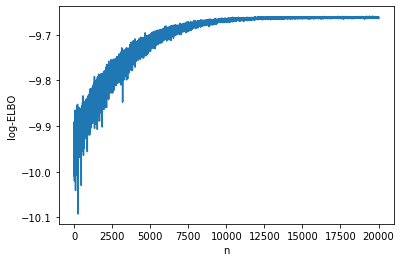

In [152]:
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)

/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model conte

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
l_day[0]  1.287  1.617   0.019    3.865      0.023    0.016    4966.0  4963.0   
l_day[1]  2.020  3.386   0.021    6.342      0.049    0.035    4721.0  4721.0   
l_day[2]  1.422  1.569   0.034    3.897      0.023    0.016    4821.0  4821.0   
l_day[3]  3.503  7.022   0.026   11.278      0.102    0.072    4770.0  4770.0   
l_day[4]  0.674  0.658   0.039    1.770      0.009    0.007    5022.0  4921.0   
...         ...    ...     ...      ...        ...      ...       ...     ...   
s2_n[45]  0.649  0.041   0.575    0.728      0.001    0.000    4956.0  4956.0   
s2_n[46]  0.719  0.046   0.632    0.805      0.001    0.000    4739.0  4729.0   
s2_n[47]  0.685  0.042   0.604    0.760      0.001    0.000    4796.0  4796.0   
s2_n[48]  0.826  0.051   0.731    0.924      0.001    0.001    4793.0  4780.0   
s2_n[49]  0.762  0.047   0.672    0.848      0.001    0.000    4861.0  4860.0   

          ess_bulk  ess_tail  r_hat  
l_day[0]    5011.0    4782.0    NaN  
l_day[1]    5049.0    4853.0    NaN  
l_day[2]    4886.0    4878.0    NaN  
l_day[3]    4756.0    4664.0    NaN  
l_day[4]    5085.0    4822.0    NaN  
...            ...       ...    ...  
s2_n[45]    4953.0    4608.0    NaN  
s2_n[46]    4754.0    4680.0    NaN  
s2_n[47]    4786.0    4944.0    NaN  
s2_n[48]    4811.0    4977.0    NaN  
s2_n[49]    4866.0    4782.0    NaN  

[2800 rows x 11 columns]

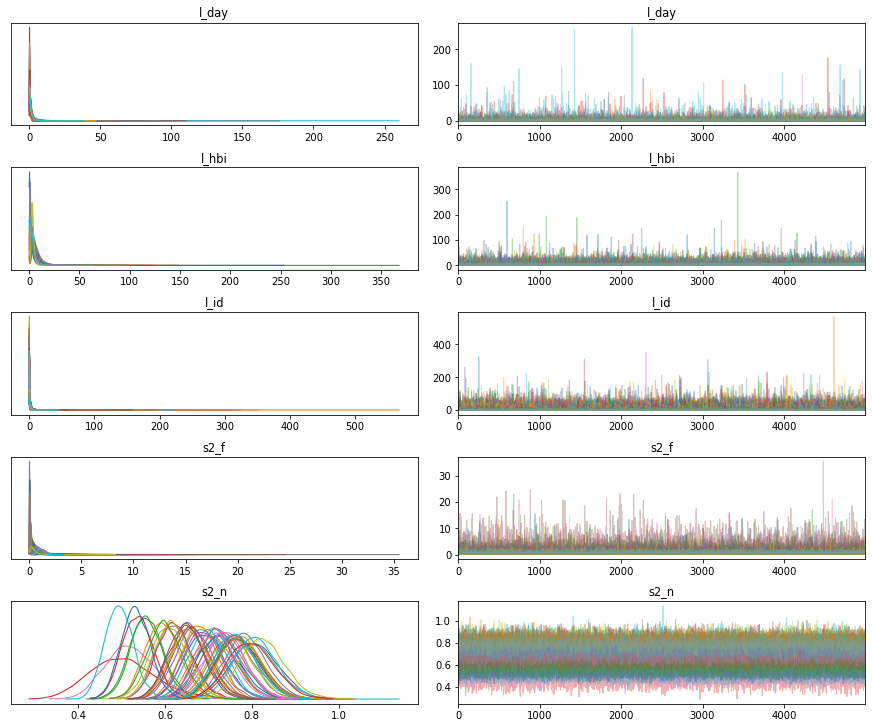

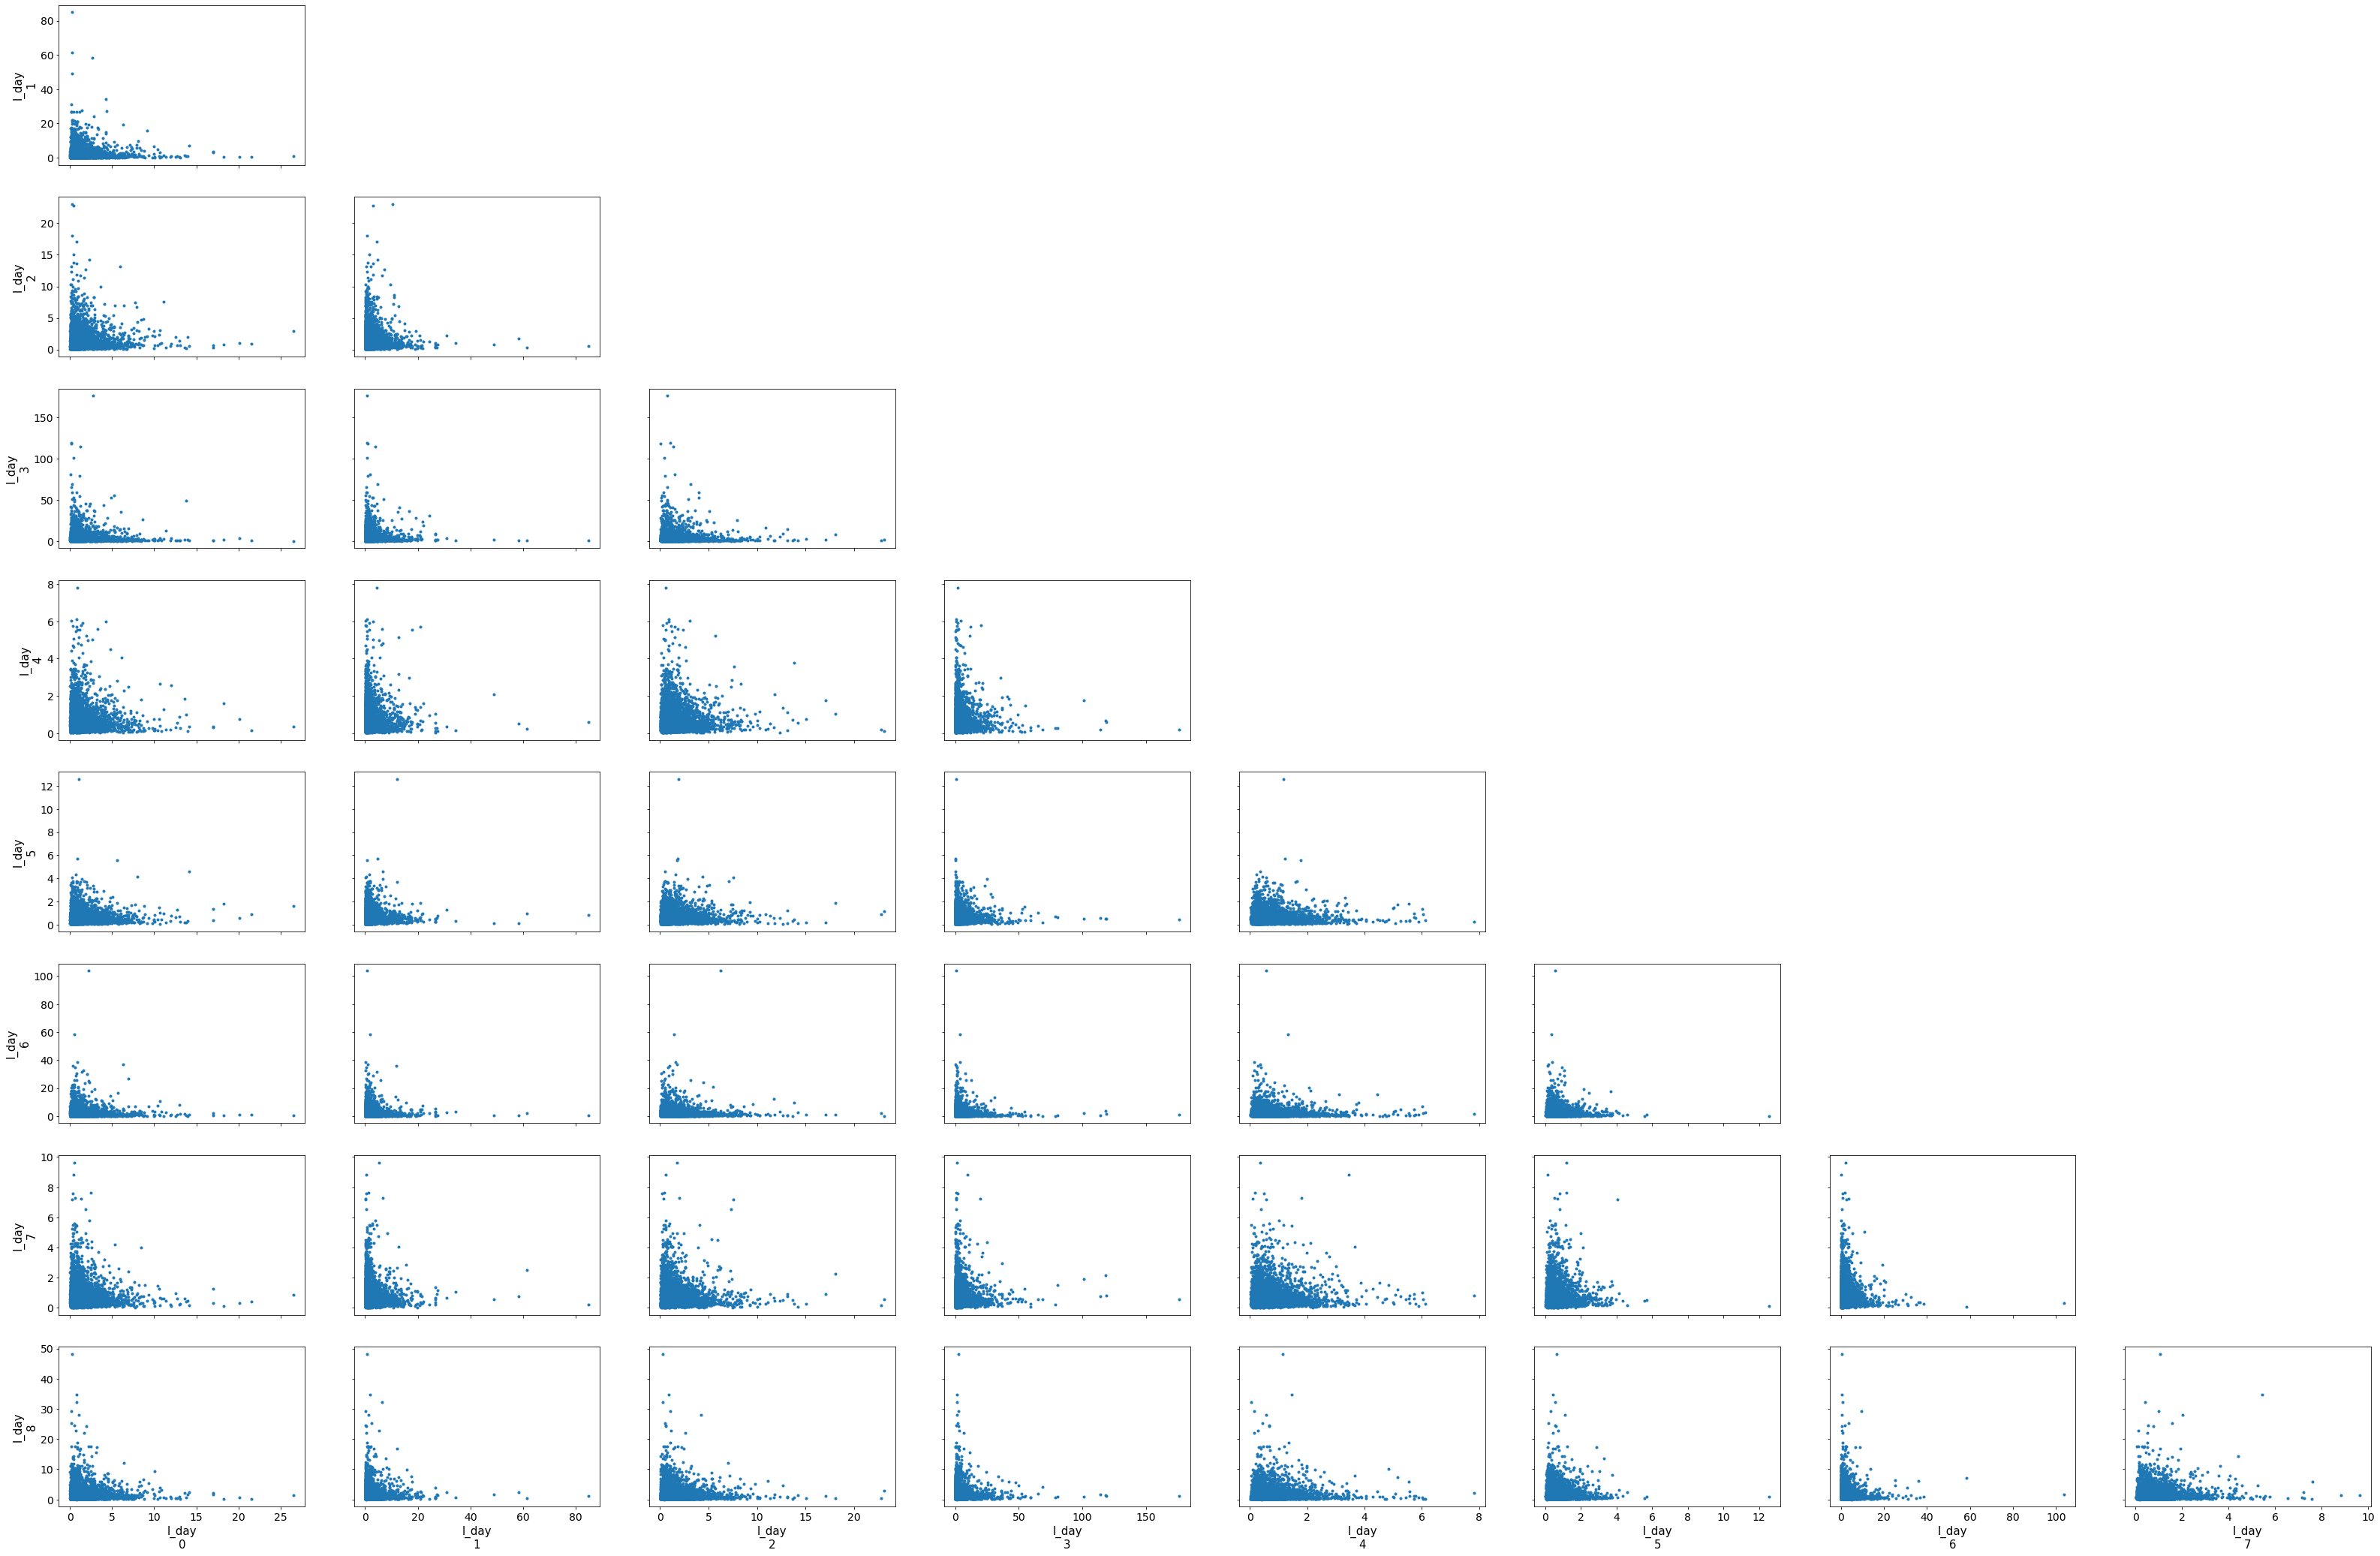

In [153]:
advi_trace = advi_fit.sample(5000)
pm.traceplot(advi_trace)
pm.pairplot(advi_trace)
pm.summary(advi_trace)

In [160]:
advi_trace.get_values(varname = 's2_f').shape

(5000, 50, 3)

In [162]:
advi_trace.get_values(varname = 's2_f').mean(axis=0)

(50, 3)

In [163]:
# Ternary plot from ADVI results 

ps.scatter_ternary(pd.DataFrame(advi_trace.get_values(varname = 's2_f').mean(axis=0),
            columns = ['time', 'disease', 'person']).assign(noise = 1/mp['s2_n']), 
                   a = 'time',
                   b = 'disease', 
                   c = 'person',
                   size = 'noise')

In [168]:
with model:
    hmc_trace2 = pm.sample(2000,
                          init = 'advi_map',
                          n_i nit = 2000,
                          random_seed = 1,
                          target_accept = 0.9,
                          tune = 500,
                          chains = 2,
                          cores = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Finished [100%]: Average Loss = 18,462
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s2_n, s2_f, l_id, l_hbi, l_day]


RecursionError: maximum recursion depth exceeded while pickling an object

/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call fr

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
l_day[0]  4.658  4.232   0.107   11.163      0.069    0.051    3790.0  3510.0   
s2_f[0]   0.533  0.637   0.019    1.534      0.012    0.008    2970.0  2970.0   
s2_n[0]   1.000  0.030   0.946    1.059      0.000    0.000    3631.0  3590.0   

          ess_bulk  ess_tail  r_hat  
l_day[0]    3379.0    1701.0    1.0  
s2_f[0]     3297.0    3262.0    1.0  
s2_n[0]     3698.0    2760.0    1.0

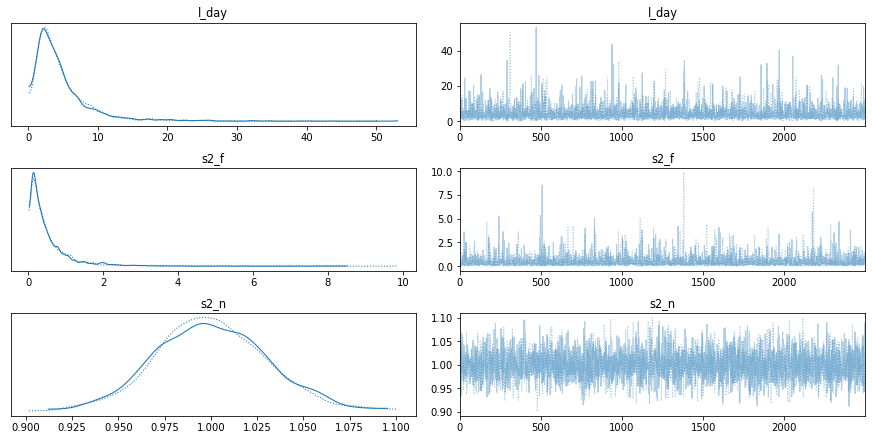

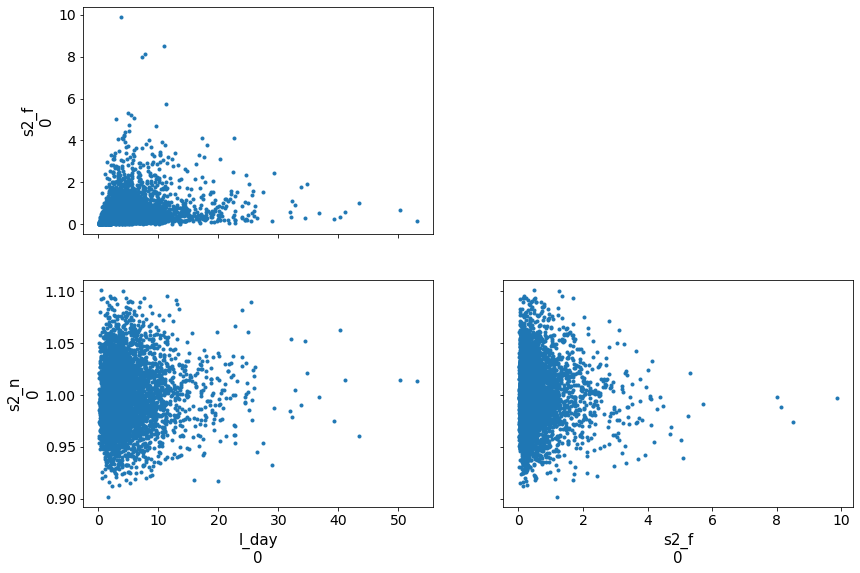

In [73]:
pm.traceplot(hmc_trace)
pm.pairplot(hmc_trace)
pm.summary(hmc_trace)

In [76]:
# add the GP conditional to the model, given the new X values
with model:
    # First get the conditional function values given posterior
    f_pred = gp.conditional('f_pred', X_new)
    
    # Now get the predictive distribution
    pred_samples = pm.sample_posterior_predictive(advi_trace, 
                                                  var_names = ['f_pred'],
                                                  random_seed = 1)
    
    # First get the conditional observation values given posterior
    y_pred = gp.conditional('y_pred', X_new, pred_noise = True)
    
    # Now get the predictive distribution
    y_samples = pm.sample_posterior_predictive(advi_trace, 
                                               var_names = ['y_pred'],
                                               random_seed = 1)

No handles with labels found to put in legend.


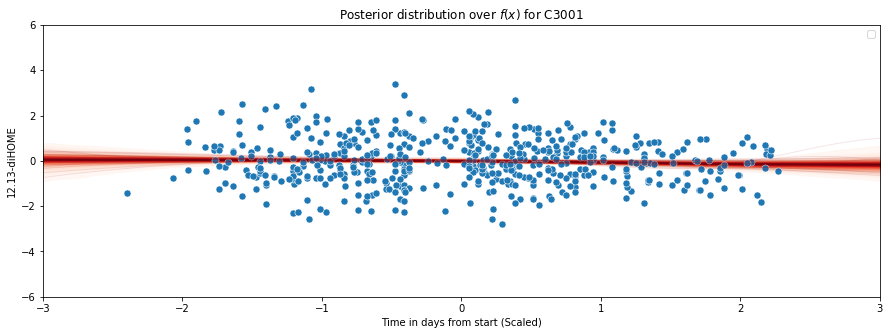

In [80]:
# Plotting 
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()
plot_gp_dist(ax, 
             pred_samples["f_pred"], 
             X_new[:,0])

# Overlay observed data
sns.scatterplot(data = df,
                x = 'days_from_start',
                y = '12.13-diHOME',
                s = 50);

# Specify labels and axes
plt.xlabel("Time in days from start (Scaled)")
plt.ylim([-6, 6])
plt.xlim([-3, 3])
plt.title("Posterior distribution over $f(x)$ for C3001")
plt.legend();

No handles with labels found to put in legend.


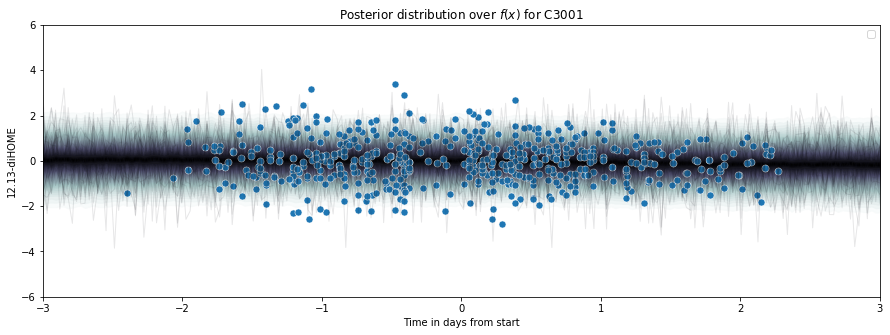

In [81]:
# Plotting PPD for observations (include noise)
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()
plot_gp_dist(ax, 
             y_samples['y_pred'], 
             X_new[:,0],
             palette = 'bone_r')

# Overlay observed data
sns.scatterplot(data = df,
                x = 'days_from_start',
                y = '12.13-diHOME',
                s = 50);

# Specify labels and axes
plt.xlabel("Time in days from start")
plt.ylim([-6, 6])
plt.xlim([-3, 3])
plt.title("Posterior distribution over $f(x)$ for C3001")
plt.legend();